In [1]:
import pandas as pd
from sklearn.datasets import load_iris

# This Projekt import
from TabDataGAN.Data.dataset import CTGan_data_set
from TabDataGAN.Benchmark.benchmark import Benchmark
from TabDataGAN.Model.Gans.WCTGan import WCTGan
from TabDataGAN.Model.Gans._gan_utils import plot_gan_losses

________________________________________________________________________________________________________________________________________________________
## Load Data

In [2]:
iris = load_iris(as_frame=True)
df = iris['frame']

________________________________________________________________________________________________________________________________________________________
## Create Custom Dataset
To use CTGAN, you need to create a custom dataset tailored to your specific needs. 

In [3]:
data_set = CTGan_data_set(
    data=df,
    cond_cols=["target"],
    cat_cols=["target"]  
)

________________________________________________________________________________________________________________________________________________________
## Create CTGAN

In [4]:
wctgan = WCTGan()

________________________________________________________________________________________________________________________________________________________
## Start the Training 
Start the training of the GAN and print the losses of Generator and Discriminator

Starting transformation with GMM; this may take a while.


/home/nicolas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting Training of the Gan
Epoch   10 || Loss Critic: -3.1452 || Loss Gen:  4.4750 || Loss Gen Extra:  1.1066|| Avg Time/Epoch: 00min:00s:079ms || Remaining Time: 00h:01min:18s:714ms
Epoch   20 || Loss Critic: -2.8621 || Loss Gen:  4.3137 || Loss Gen Extra:  1.1120|| Avg Time/Epoch: 00min:00s:076ms || Remaining Time: 00h:01min:14s:816ms
Epoch   30 || Loss Critic: -2.1169 || Loss Gen:  3.2324 || Loss Gen Extra:  1.0922|| Avg Time/Epoch: 00min:00s:075ms || Remaining Time: 00h:01min:13s:285ms
Epoch   40 || Loss Critic: -1.6426 || Loss Gen:  2.1305 || Loss Gen Extra:  1.1096|| Avg Time/Epoch: 00min:00s:075ms || Remaining Time: 00h:01min:12s:383ms
Epoch   50 || Loss Critic: -1.4229 || Loss Gen:  1.4626 || Loss Gen Extra:  1.1009|| Avg Time/Epoch: 00min:00s:075ms || Remaining Time: 00h:01min:11s:306ms
Epoch   60 || Loss Critic: -1.3939 || Loss Gen:  1.1672 || Loss Gen Extra:  1.1066|| Avg Time/Epoch: 00min:00s:074ms || Remaining Time: 00h:01min:10s:283ms
Epoch   70 || Loss Critic: -1.4055 

/tmp/ipykernel_9665/1462472356.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


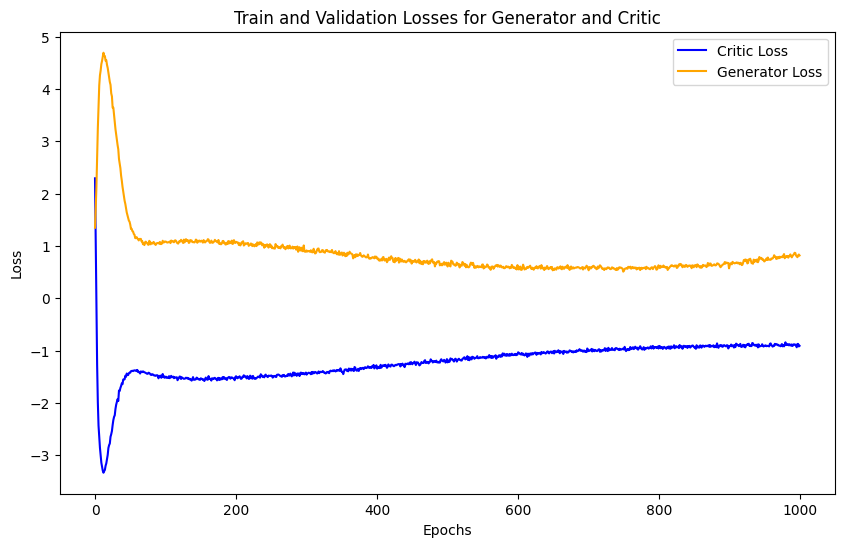

In [5]:
crit_loss, gen_loss = wctgan.fit(
    data_set,
    n_epochs=1000
)

fig = plot_gan_losses(crit_loss, gen_loss)
fig.show()

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________
### Save and Load Model

In [6]:
wctgan.save()   # provide save part if you dont want to save it with the base path

wctgan_loaded = WCTGan()

wctgan_loaded.load()

________________________________________________________________________________________________________________________________________________________
##  Create New Conditional Data

To create data given a condition, just create a DataFrame that represents the condition. 
Generating data with a condition doesn’t guarantee that all generated data will strictly 
adhere to that condition, but it will influence the generation process.

If you want to create data with no specific condition, simply pass the number of points 
you want to generate.

In [7]:
cond_df = pd.DataFrame([{"target" : 1}]*160)
syn_df_ = wctgan_loaded.gen(cond_df=cond_df)  

# or
syn_df = wctgan.gen(160)  

print(syn_df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0             5.399725          3.099836           1.499864          0.199844   
1             5.699885          3.762906           1.224228          0.299893   
2             6.099784          2.999892           5.379166          2.099875   
3             6.705874          2.699836           5.646837          1.999889   
4             5.699817          2.999908           4.187671          1.399901   
..                 ...               ...                ...               ...   
155           7.703977          2.999908           5.642699          2.099938   
156           5.599845          2.699840           1.499785          1.299893   
157           5.499861          2.299887           4.185039          1.299933   
158           4.957902          3.199844           1.225248          0.199902   
159           6.262930          2.999882           4.734263          0.408799   

    target  
0        0  
1

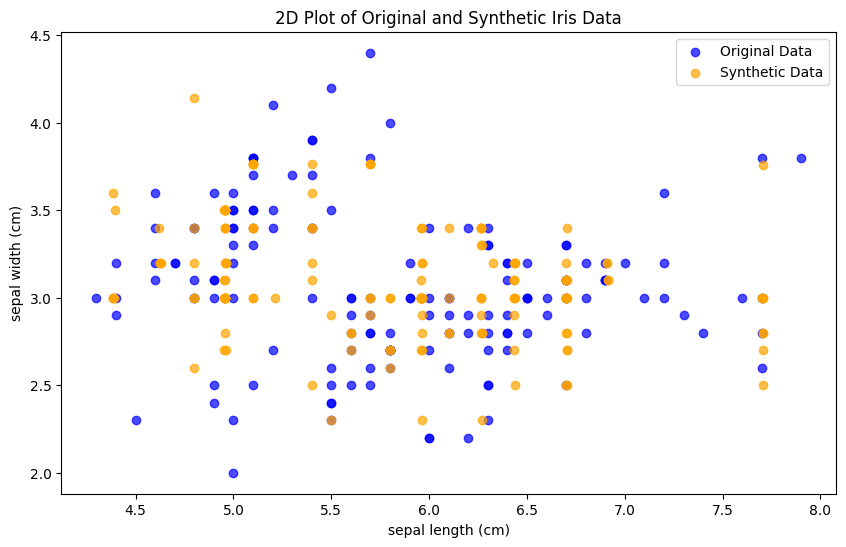

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], color="blue", label="Original Data", alpha=0.7)
plt.scatter(syn_df.iloc[:, 0], syn_df.iloc[:, 1], color="orange", label="Synthetic Data", alpha=0.7)
plt.xlabel(iris['feature_names'][0])
plt.ylabel(iris['feature_names'][1])
plt.title("2D Plot of Original and Synthetic Iris Data")
plt.legend()
plt.show()

### Benchmark the Generated Data

There are various ways to benchmark generated data. In the benchmark class, several methods are implemented that you can use to validate your generated data. However, it’s worth noting that GANs often struggle to accurately replicate even simple data distributions

The first measure is a Linear Regression classifier where we try to distinguish between the real and the generated data using Linear Regression

In [9]:
benchmark = Benchmark()
mean_lr = benchmark.mean_lr(df, syn_df)

print(mean_lr)

0.36451612903225805


Now we can look at a pairwise column correlations plot that shows the absolute difference between the real data covariance and the generated data covariance (lower indicates better performance). 

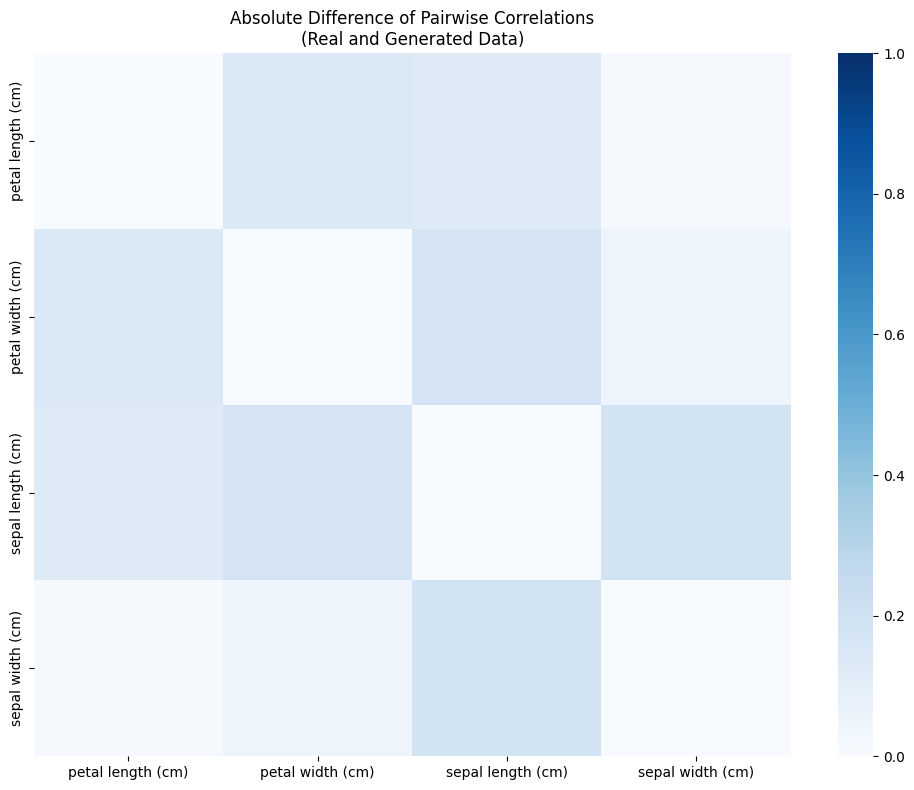

In [10]:
benchmark.absCorrPlot(df, syn_df, cat_cols=["target"]);

Now we can look at a covariance plot that shows the absolute difference between the real data covariance and the generated data covariance (lower indicates better performance). 

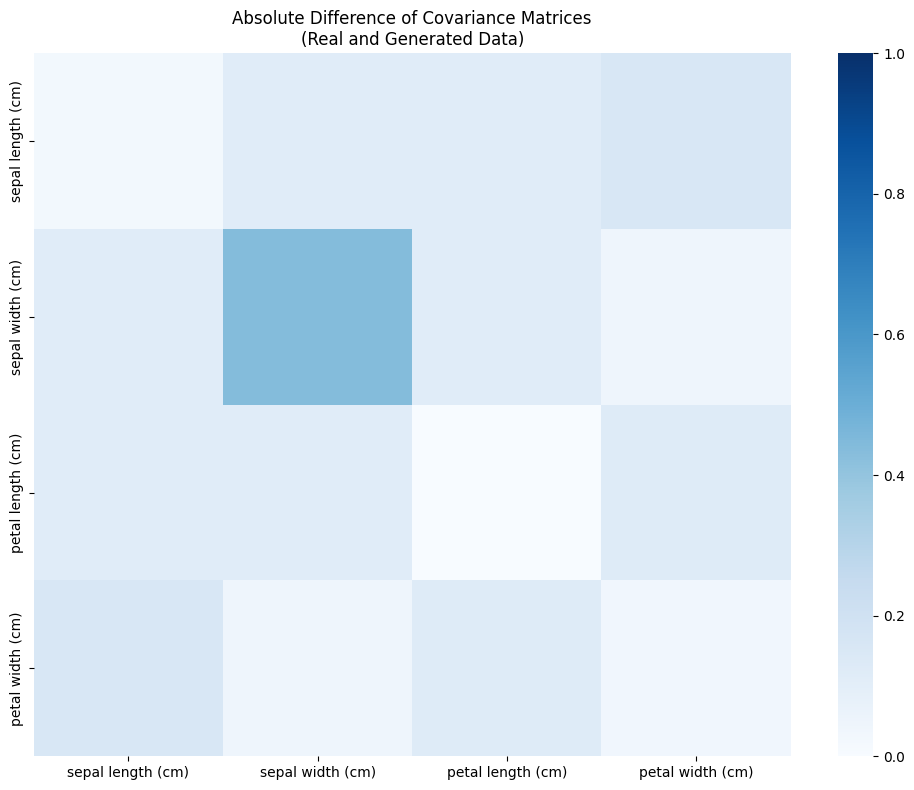

In [11]:
benchmark.absCovPlot(df, syn_df, cat_cols=["target"]);